# Hydrograph Development Notebooks

## Create a Levee Breach Hydrograph for 3 locations using Steady RAS Results 

### Example: Whitney Point, NY

In [11]:
import os
from glob import glob

from importlib import reload
import utils; reload(utils)
from utils import *
import ny_clean_nb; reload(ny_clean_nb)
from ny_clean_nb import *

import pandas as pd
import numpy as np
from scipy import interpolate 

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Gage data  and Results from HEC-RAS hdf file

In [12]:
import ny_clean_nb; reload(ny_clean_nb)
from ny_clean_nb import *
gage_data = initialize()

01509000_00060_dv.tsv
01509000_00060_iv.tsv
01509000_00065_iv.tsv
01509520_00065_iv.tsv
01511500_00065_iv.tsv


### Read in  Base Hydrograph & Scale to 1-pct

C:\Users\slawler\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:222: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


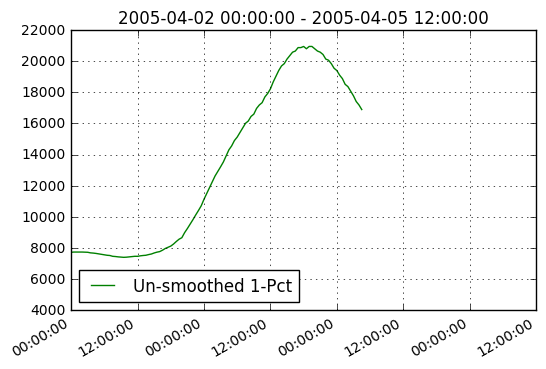

In [13]:
# Method #1
breach_height = 950.22

pct_1_peak, inst_peak  = Stretched_Daily_100yr(gage_data, plot = False)
peak =  14209.0
pct_1 = 20960.0
stretch_1pct = pct_1/peak 
smooth_storm_resample = inst_peak.resample('30T').mean()
smooth_storm_1pct = smooth_storm_resample*stretch_1pct
#print('Factor: \n','\t1 Percent\t{}'.format(stretch_1pct))

f, ax = plt.subplots()
ax.plot(smooth_storm_1pct,color = 'green',label = 'Un-smoothed 1-Pct')
ax.grid()
ax.legend(loc='best')
title = '{} - {}'.format(smooth_storm_1pct.index[0],smooth_storm_1pct.index[-1])
ax.set_title(title)

f.set_size_inches(6,4)
f.autofmt_xdate()

### Manually Smooth the curve where needed:
*See comment lines for smoothing procedure.*

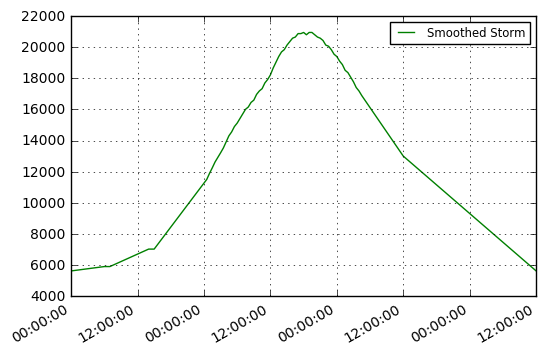

In [14]:
# 1. Make a copy of the unsmoothed hydrograph: 
final_hydrograph  = smooth_storm_1pct.copy()

#2. Replace the dates of the portions needing to be smoothed with NaNs
final_hydrograph['2005-04-02 00:00':'2005-04-03 00:00'] = np.nan #

#3. Set the first data point to the desired starting value 
# Note: Typically the starting and ending values will be the same, for this example the min works
final_hydrograph['2005-04-02 00:00':'2005-04-02 00:00'] = float(final_hydrograph.min())

#4. Add more points as needed to smooth the curve
# Note: This is an iterative process, using a (factor*min) appproach is used here for speed of iteration 
final_hydrograph['2005-04-02 06:00':'2005-04-02 07:00'] = float(final_hydrograph.min()*1.05)
final_hydrograph['2005-04-02 14:00':'2005-04-02 15:00'] = float(final_hydrograph.min()*1.25)

#5. Smooth the iterated points
smooth_storm = final_hydrograph.interpolate(how = 'polynomial', order=3) 

f, ax = plt.subplots()
ax.plot(smooth_storm,color = 'green',label = 'Smoothed Storm')
ax.grid()
ax.legend(loc= 'best',  fontsize='small')

f.set_size_inches(6,4)
f.autofmt_xdate()

# Procedure to create Breach Hydrograph

    1. Read in RAS data for XS of interest & create stage/discharge Rating Curve

    2. Convert River Discharge to stage using the rating curve from HEC-RAS

    3. Translate Stage to head (above selected breach height) and compute weir flow  
    
    4. Write calculated weir flow to file & input into HEC-RAS unsteady flow file

#### The Standard Weir Equation:
$$ Q = CLH^{2/3} $$

Where:  Q = discharge, C =weir coefficient, L = weir crest length, H = Energy head over the weir crest.


*From HEC-as Lateral Wier Coefficients, default Weir Coefficient of 2.0 (range is 1.5-2.6, given on page 3-50 of the 2D Manual)*

### Breach Location # 1:
![](images\43305.79_location_1.JPG)

**RAS Data for XS 43305.79**

C:\Users\slawler\Repos\HydrologyTools\utils.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if plot:


**
Inflow Data for Breach Location**

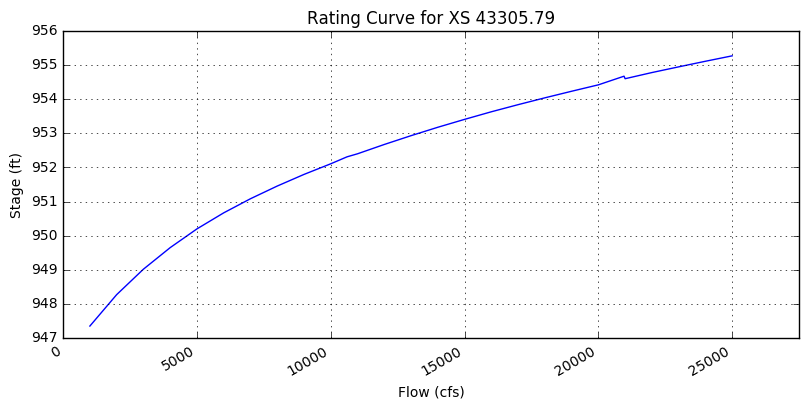

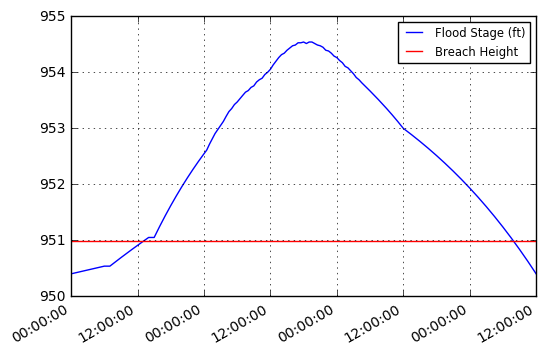

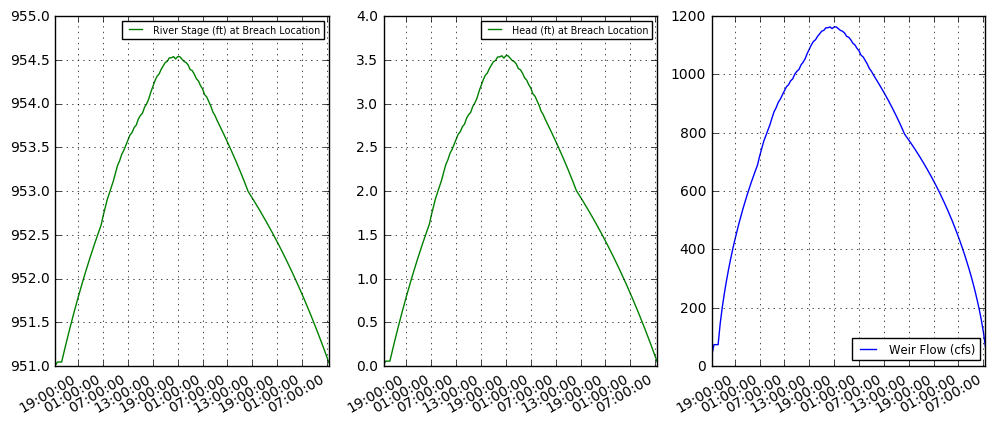

In [15]:
rasdata = r'p:\02\NY\Broome_Co_36007C\LAMP2\TECH\Analysis\Modeling\WorkingModels\Lisle_WhitPt\LAMPRAS\Lisle_WhitPt.p05.hdf'
station = 43305.79
breach_point = 1
breach_height = 950.99

df = GetRasData(rasdata, station)

# Plot a Rating Curve using Stage & Flow data
StageDischargePlot(df, figsize=(8,4))

poly_order = 3
polyfit  = np.polyfit(df['flow'],df['stage'],poly_order)
polyfitline = np.poly1d(polyfit) 

hydro =pd.DataFrame(smooth_storm)
stage = plotcomp(hydro, polyfitline,breach_stage =breach_height)

df_weir = ComputeWeirFlow(stage,breach_height) 
printbold('\nInflow Data for Breach Location')
output_csv = os.path.join(os.getcwd(),'computed_data', 'BreachData_{}_location_{}.tsv'.format(station, breach_point))
df_weir.to_csv(output_csv, sep = '\t')

### Breach Location # 2:
![](images\40800.30_location_2.JPG)


**
Inflow Data for Breach Location**

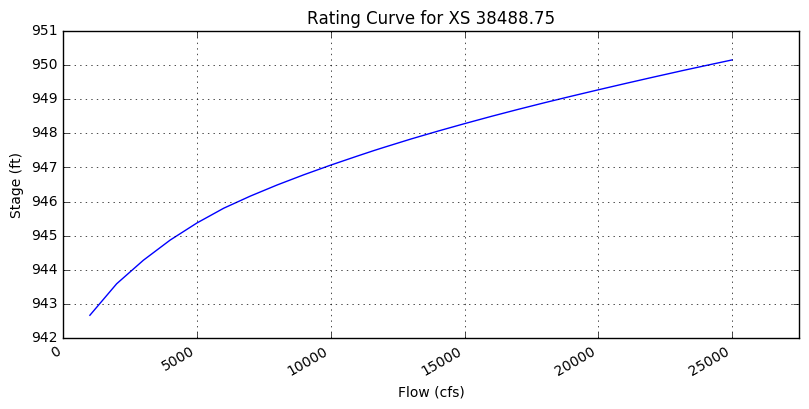

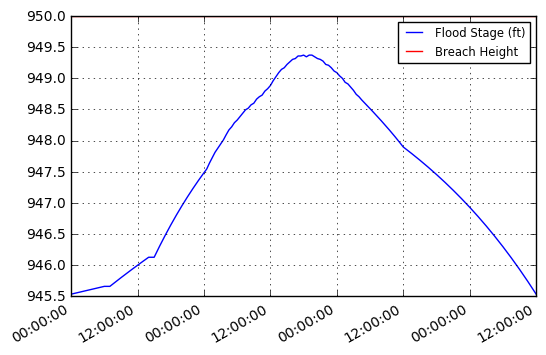

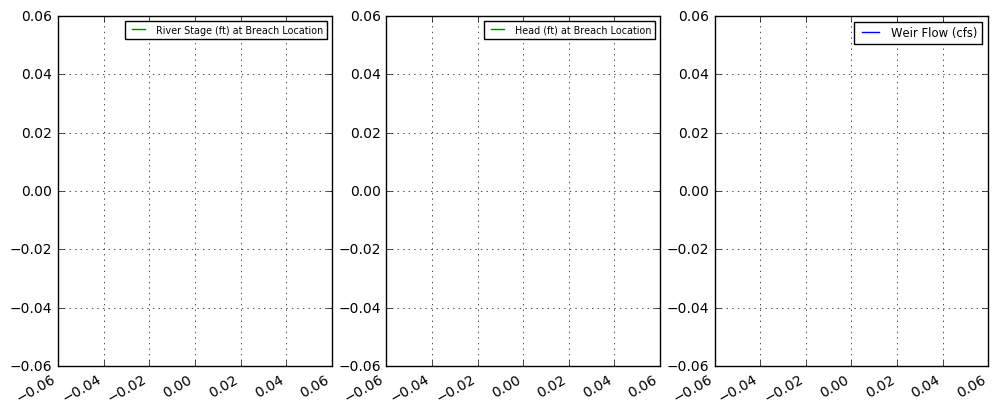

In [41]:
rasdata = r'p:\02\NY\Broome_Co_36007C\LAMP2\TECH\Analysis\Modeling\WorkingModels\Lisle_WhitPt\LAMPRAS\Lisle_WhitPt.p05.hdf'
station = str('40800.30')
breach_point = 2
breach_height = 950.00

# Plot a Rating Curve using Stage & Flow data
StageDischargePlot(df, figsize=(8,4))

poly_order = 3
polyfit  = np.polyfit(df['flow'],df['stage'],poly_order)
polyfitline = np.poly1d(polyfit) 

hydro =pd.DataFrame(smooth_storm)
stage = plotcomp(hydro, polyfitline,breach_stage =breach_height)

df_weir = ComputeWeirFlow(stage, breach_height) 
printbold('\nInflow Data for Breach Location')
output_csv = os.path.join(os.getcwd(),'computed_data', 'BreachData_{}_location_{}.tsv'.format(station, breach_point))
df_weir.to_csv(output_csv, sep = '\t')

### Breach Location # 3:
![](images\38488.75_location_3.JPG)


**RAS Data for XS 38488.75**

**
Inflow Data for Breach Location**

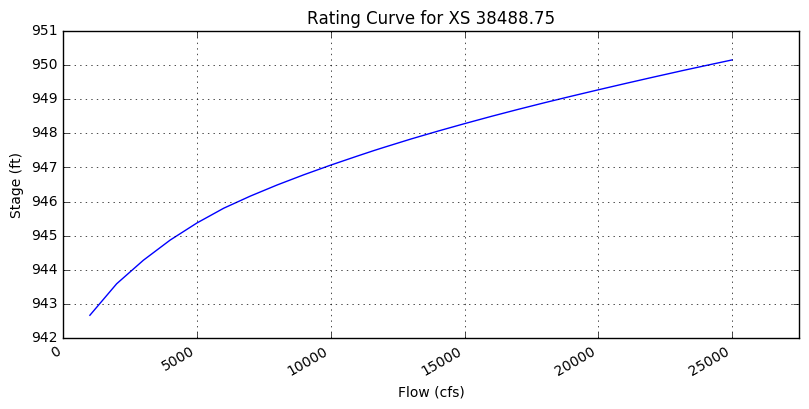

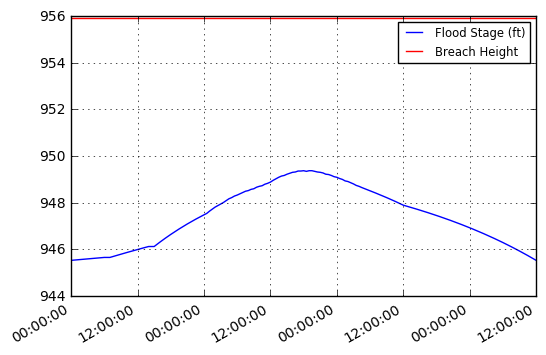

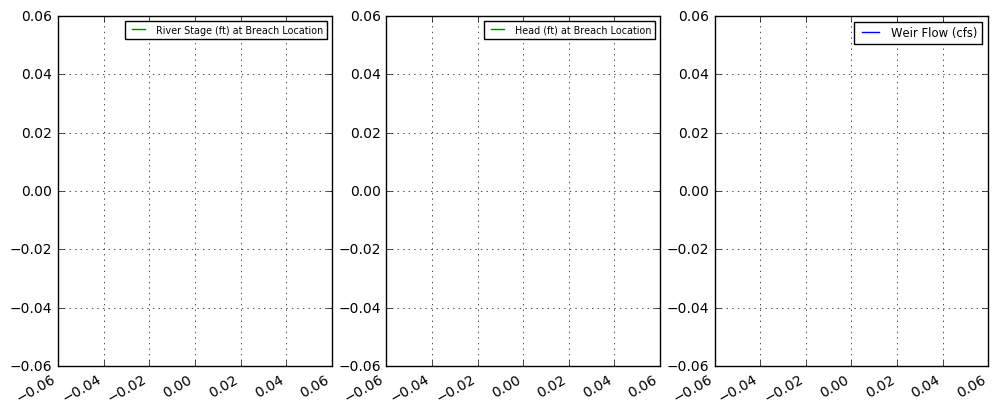

In [17]:
rasdata = r'p:\02\NY\Broome_Co_36007C\LAMP2\TECH\Analysis\Modeling\WorkingModels\Lisle_WhitPt\LAMPRAS\Lisle_WhitPt.p05.hdf'
station = 38488.75
breach_point = 3
breach_height = 955.93

df = GetRasData(rasdata, station)

# Plot a Rating Curve using Stage & Flow data
StageDischargePlot(df, figsize=(8,4))

poly_order = 3
polyfit  = np.polyfit(df['flow'],df['stage'],poly_order)
polyfitline = np.poly1d(polyfit) 

hydro =pd.DataFrame(smooth_storm)
stage = plotcomp(hydro, polyfitline,breach_stage =breach_height)

df_weir = ComputeWeirFlow(stage, breach_height) 
printbold('\nInflow Data for Breach Location')
output_csv = os.path.join(os.getcwd(),'computed_data', 'BreachData_{}_location_{}.tsv'.format(station, breach_point))
df_weir.to_csv(output_csv, sep = '\t')